# <center> L-TEM analysis of Magnetic Samples with MTIE</center>

This code will align the different images of magnetic samples captured using Lorentz microscopy (underfocus, infocus and overfocus) and calculates the magnetization of the sample using the transport of intensity equation (TIE)

author: Dr. Joseph Vas & Prof. Martial Duchamp

This code is developed based on the MTIE equation for quantifying magnetic domains measured using Lorentz TEM in a JEOL ARM 300 double corrected microscope in a field free conditions by switching off the objective lens. The image focus is done by the loretz lens available with the image corrector. The probe corrector is switched off except for the lens responsible for correcting the 2 and 3 stig.

The main reference for the algorithm is given below. 
<br>[1] V.V Volkov, Y Zhu, Lorentz phase microscopy of magnetic materials, Ultramicroscopy, Volume 98, Issues 2–4, 2004,pp. 271-281, ISSN 0304-3991,https://doi.org/10.1016/j.ultramic.2003.08.026.
<br>[2] https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/

The formulation for the MTIE is given in [1].

The key equations for the calculation are





1. $\phi(r) = F^{-1}[F(k_{z}\delta_{z}I/I)/k_\bot^{2}]$
2. $t{B} = \frac{\hbar}{e}[n_{z}\times \Delta\phi]$

The algorithm used will be as follows,
<br>(1) Import the 3 images - under focus, in focus and over focus images
<br>(2) calculating the homography transform matrix of the underfocus and overfocus images with respect to the infocus image and aligning the out of focus images to the in-focus image
<br>(3) masking the areas with large fresnal frignes to eliminate spurious results
<br>(4) calculating the phase shift to the electron wave due to magnetic fields of the sample using equation 1.
<br>(5) Calculating the magnetic induction from the phase shift
<br>(6) calculating the magnetic field from the phase shift using equation 2.

## <center>This version of the code is optimized for working with Lorentz images with only 1 defocus </center>

<ins>Step 1</ins>. Importing the different dm4 images - underfocus, infocus and overfocus

<ins>importing relevant python libraries</ins>

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cv2
from scipy import ndimage
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label, regionprops
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom, binary_fill_holes
import plotly.graph_objects as go
import hyperspy.api as hs
import math
pi = np.pi
import glob
import os
from scipy import interpolate
from sklearn.cluster import KMeans
from scipy.ndimage import rotate

In [2]:
%matplotlib inline
#%pylab qt

<ins>importing the in-focus and out of the focus images collected in L-TEM</ins>

<br>Before the transforms can be done, in-order to reduce the processing time, the images need to be binned down. This is written as a separate function

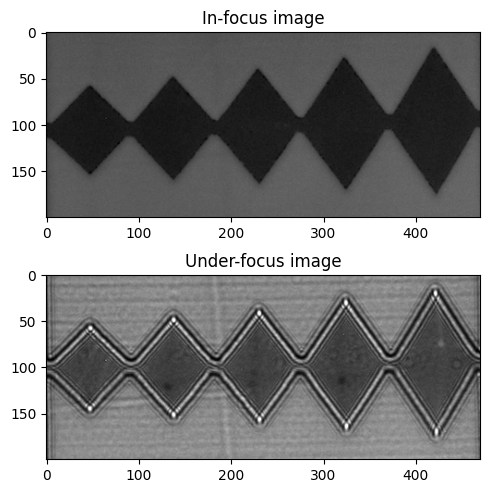

In [ ]:
TEM2 = hs.load(r"\OneView-100kX-0209.dm4") #in-focus
# for saving the data
TEM1 = hs.load(r"\7.5 mA.dm4")

rebin_order = 8 #the order by which the size is to be binned
bin_sizex = TEM1.data.shape[0]/rebin_order
bin_sizey = TEM1.data.shape[1]/rebin_order

under_focus = TEM1.rebin([bin_sizex,bin_sizey])
TEM1N = under_focus
in_focus = TEM2.rebin([bin_sizex,bin_sizey])
TEM2N = in_focus
fig, ax = plt.subplots(2,1,figsize=(5,5))
ax[0].imshow(rotate(TEM2N.data,-7)[190:390,50:520],cmap = "gray",vmax=1.5*np.mean(TEM2N.data))
ax[0].set_title('In-focus image')

ax[1].imshow(rotate(TEM1N.data,-7)[190:390,50:520],cmap = "gray",vmax=1.5*np.mean(TEM1N.data))
ax[1].set_title('Under-focus image')
plt.tight_layout()
plt.show()

<ins>Step 2.</ins> Calculating the homography transform matrix of the underfocus and overfocus images with respect to the infocus image and aligning the out of focus images to the in-focus image.
<br> Before the phase information and the fields can be calculated from the L-TEM images, the artifacts brought in due to the defocus needs to be calculated. This is done by calculating the transforamtion- homography which takes into account the translation, rotation and sheer transformations due to the defocus. Another defocus effect is the introduction of fresnal fringes at the edges of the samples. This cannot be easily removed and thus is ignored.


<ins>aligning the images with respect to the in-focus image</ins>

<br> The transformation matrix is calculated in 2 stages, the first one to find the translation between the images. Once the translation is corrected, the rotation and sheer of the images are corrected for using the homography transform.

This function is used to calculate the translation, rotation and sheer transformation between the in-focus image and out of focus images

In [4]:
def align2d_cv(template_original,image_original,warp_mode): #function for calculating the alignments
    
    template = template_original.copy()
    image = image_original.copy()

    template_mean = np.mean(template)
    image_mean = np.mean(image)

    template[template>template_mean] = template_mean
    image[image>image_mean] = image_mean

    template[template<template_mean] = 0
    image[image<image_mean] = 0

    temp = cv2.normalize(template, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    imag = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    #find the shape
    sz = image.shape
    print(sz)

    #defining the mask
    mask = temp.copy()
    #mask_mean = np.mean(mask)
    #mask[mask>0.9*mask_mean] = 1
    #mask[mask<0.9*mask_mean] = 0

    mask[:,:] = 1
    mask[0,0] = 0
    
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
        
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
          
     # Specify the number of iterations.
    number_of_iterations = 3000;
    
    # Specify the threshold of the increment
    termination_eps = 1e-10;
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(temp,imag,warp_matrix, warp_mode, criteria,mask,gaussFiltSize = 5)
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix[0,2] = warp_matrix[0,2] +4
        warp_matrix[1,2] = warp_matrix[1,2] -1.5
                # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (image_original, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(image_original, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        print(warp_matrix)
    return(im2_aligned)      

In [5]:
under_focus_translated = align2d_cv(in_focus.data, under_focus.data, cv2.MOTION_TRANSLATION)
under_focus_affined = align2d_cv(in_focus.data, under_focus_translated, cv2.MOTION_HOMOGRAPHY)

(512, 512)
[[ 1.         0.        -0.7707374]
 [ 0.         1.        -1.4731958]]
(512, 512)


<ins>Plotting to check the alignments</ins>

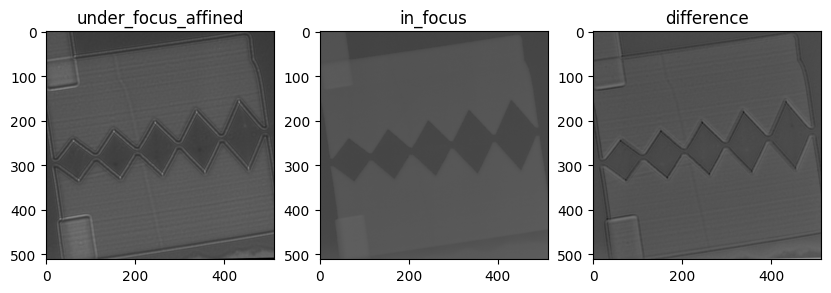

In [6]:
vmin_mul = 0.05
vmax_mul = 3

fig, ax = plt.subplots(figsize = (10,14),nrows = 1, ncols= 3)
image =under_focus_affined
ax[0].imshow((image), cmap='gray', \
                 vmin=vmin_mul*np.mean(image), vmax=vmax_mul*np.mean(image))
ax[0].set_title('under_focus_affined')

image =in_focus.data
ax[1].imshow((image), cmap='gray', \
                 vmin=vmin_mul*np.mean(image), vmax=vmax_mul*np.mean(image))
ax[1].set_title('in_focus')
#ax[1].savefig('infocus png')

image =in_focus.data-under_focus_affined
ax[2].imshow((image), cmap='gray', \
                vmin=vmin_mul*np.mean(image), vmax=vmax_mul*np.mean(image))
ax[2].set_title('difference')
plt.show()

<ins>Step 3.</ins> Creating the mask containing the region of interest
<br> Three things need to be done for a good mask. <br>(1) Remove the high frequency noise within the region of interest. This is done by fft filtering here. <br>(2) Remove the outer edges which are not of interest to the study. This is done by using a rectangle to cut off that region. <br>(3) remove a buffer layer from the edge to remove the areas influenced by fresnal fringes

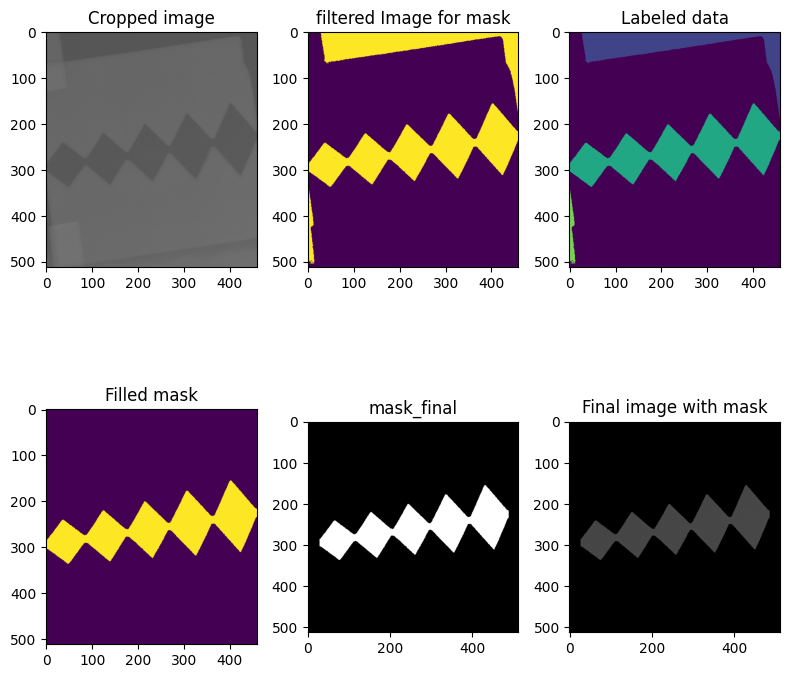

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
x_lim1 = 28
x_lim2 = -25
TEM2_data = TEM2N.data
ax[0, 0].imshow(TEM2_data[:,x_lim1:x_lim2], cmap='Greys_r',vmin=vmin_mul*np.mean(np.array(TEM2_data)), vmax=vmax_mul*np.mean(np.array(TEM2_data)))
ax[0, 0].set_title('Cropped image')# Add colorbar to the first subplot

c = np.max(TEM2_data[:,x_lim1:x_lim2]) # can be changed according to the image contrast
mask = TEM2_data[:,x_lim1:x_lim2] < 3*c/4

ax[0, 1].imshow(mask)
ax[0, 1].set_title('filtered Image for mask')

mask_labeled = label(mask) # assigning each part of the image a label
ax[0,2].imshow(mask_labeled)
ax[0,2].set_title("Labeled data")

slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps] # area of slices created in the array
idxs = np.argsort(areas)[::-1] # we want largest to smallest area
new_slc = np.zeros_like(slc)
for i in idxs[:1]:
    new_slc[tuple(rps[i].coords.T)] = i+1
mask_f = new_slc>0
mask_ff= binary_fill_holes(mask_f) # there is no empty places inside the selected area of the image
ax[1,0].imshow(mask_ff)
ax[1,0].set_title('Filled mask')

mask_int = mask_ff.astype(int)
mask_final = np.zeros_like(np.array(TEM2N),dtype=int)

mask_final[:,x_lim1:x_lim2] = mask_int
ax[1,1].imshow(mask_final,cmap='gray')
ax[1,1].set_title('mask_final')

img = np.array(TEM2_data)*mask_final
ax[1,2].imshow(img,cmap='gray',vmin=vmin_mul*np.mean(np.array(TEM2_data)), vmax=vmax_mul*np.mean(np.array(TEM2_data)))
ax[1,2].set_title("Final image with mask")
plt.tight_layout()
plt.show()

<br>The mask is created from infocus image. We can even further crop the edges to get rid of Fresnel diffraction.

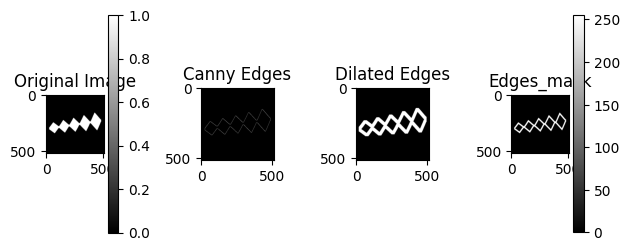

In [8]:
# Assuming mask_final is a NumPy array
if len(mask_final.shape) == 3 and mask_final.shape[2] == 3:
    # Check if the image is not already in grayscale
    gray_image = cv2.cvtColor(mask_final, cv2.COLOR_BGR2GRAY)
else:
    # Image is already in grayscale
    gray_image = mask_final.astype(np.uint8)  # Ensure the correct data type

# Apply GaussianBlur to reduce noise and help edge detection
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Use the Canny edge detector with adjusted parameters
edges = cv2.Canny(blurred_image, 1, 1)  # Adjust the thresholds if needed

# Display the original and processed images
plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.colorbar()
plt.subplot(1, 4, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')

# Dilate the edges
kernel = np.ones((3, 3))
dilated_edges = cv2.dilate(edges, kernel, iterations= 8)

plt.subplot(1, 4, 3)
plt.imshow(dilated_edges, cmap='gray')
plt.title('Dilated Edges')
edges_mask = (dilated_edges*mask_final)

plt.subplot(1, 4, 4)
plt.imshow(edges_mask, cmap='gray')
plt.title('Edges_mask')
plt.colorbar()
plt.tight_layout()

plt.show()

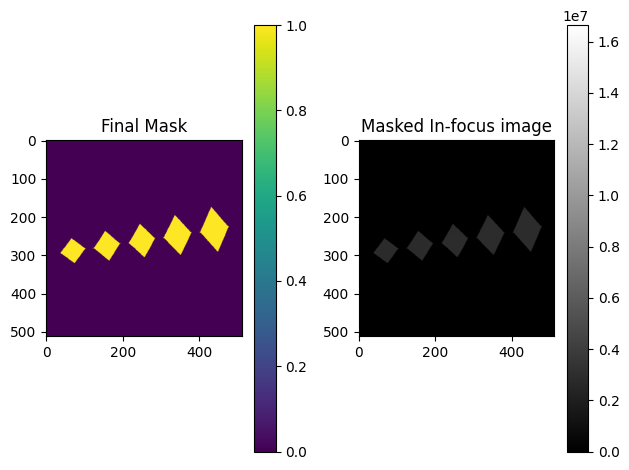

In [9]:
# Display the original and processed images

reu_mask = gray_image - edges_mask//250
plt.subplot(1, 2, 1)
plt.imshow(reu_mask)
plt.colorbar()
plt.title('Final Mask')

plt.subplot(1, 2, 2)
mask = in_focus.deepcopy()
mask_mean = np.mean(mask.data)
mask.data = mask.data*reu_mask
plt.imshow(mask.data,cmap = 'gray',vmax=5*mask_mean,vmin=0)
plt.title('Masked In-focus image')
plt.colorbar()
plt.tight_layout()
plt.show()

<ins>Step 4.</ins> Calculating the phase of the wave due to magnetic sample. 
<br>Since we need to find the log of the intensity difference, having zero intensity in the data creates singularities. This has to be corrected before calculating the log.

<br>The calculating involves constants which can depend on the accelarating voltage which needs to be corrected for relativistic effects. One of the important constants is the defocus used for the measurements. This needs to be inputted.

In [10]:
#preventing singularity while taking log
under_focus_affined = under_focus_affined +0.001
in_focus_data = in_focus.data + 0.001

average_intensity = (under_focus_affined+in_focus_data)/2

#need to change with actual change of focus
df = 3000e-9*5e3 

#constants to be inputted
h = 6.626e-34
m = 9.1e-31
electron_charge = 1.6e-19
V = 388.06e3 # accelarating voltage corrected for relativistic effects
lamda = h/math.sqrt(2*m*electron_charge*V)
kz = 2*pi/lamda #this is for vacuum since the wave transformation between under focus and overfocus is in vacuum
t = 5e-9, #thickness of the sample

#calculating the part of equation 1 which will be FFTed
dz_logI = (under_focus_affined-in_focus_data)/(average_intensity*df)
#dz_logI = (log_over-log_under)/(df)
#dz_logI[mask.data<0.2] = 0 #applying mask
#dz_logI[dz_logI==0] = 1/kz

fft_dI = np.fft.fft2(kz*dz_logI)
fft_dI_shift = np.fft.fftshift(fft_dI)

#finding the k space vectors
pixel_dimensions = 18.747e-9*in_focus.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension.TagGroup0.Scale*rebin_order
field_of_view = dz_logI.shape[0]*pixel_dimensions
#pixel_dimensions = 1

FreqCompRows = np.fft.fftfreq(dz_logI.shape[0],d=pixel_dimensions)
FreqCompCols = np.fft.fftfreq(dz_logI.shape[1],d=pixel_dimensions)


k_perp1 = np.zeros(dz_logI.shape)

for i in range(0,k_perp1.shape[0]):
    for j in range(0,k_perp1.shape[1]):
        k_perp1[i,j]= np.sqrt(FreqCompRows[i]*FreqCompRows[i]+FreqCompCols[j]*FreqCompCols[j])
        #if k_perp[i,j]< 1e6:
            #k_perp[i,j] = inf

#k_perp1[0,0] = 0.5e5 #removing the singularity caused when k_perp becomes 0
k_perp = np.fft.fftshift(k_perp1)+np.max(k_perp1)/0.5e2 # use a sufficiently small number to avoid the low frequency noise 
#k_perp[k_perp<5e5] = 5e5
fft_part = (fft_dI_shift/(k_perp**2))

#calculalating the phase of the wave when passing throught the sample
phi_crop = abs(np.fft.ifft2(np.fft.ifftshift(fft_part)))


In [11]:
pixel_dimensions = 18.747e-9*in_focus.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension.TagGroup0.Scale*rebin_order

<br>Importing neccessary libraries for phase analysis

In [12]:
import os

import matplotlib.patches as patches
from skimage.restoration import unwrap_phase
from skimage.transform import rotate
from skimage.measure import block_reduce
import empyre as emp

from libertem.api import Context
from libertem.udf.raw import PickUDF
from libertem_holo.udf.reconstr import HoloReconstructUDF

from libertem_holo.base.filters import (
    clipped, disk_aperture, butterworth_disk, butterworth_line,
)
from libertem_holo.base.utils import (
    estimate_sideband_position, estimate_sideband_size, freq_array, HoloParams, get_slice_fft, fft_shift_coords,
    remove_phase_ramp,
)
from libertem_holo.base.reconstr import phase_offset_correction
from libertem_holo.base.align import align_stack, ImageCorrelator, stack_alignment_quality

This function is used to plot the Mangetic induction from phase file using "empyre" library

In [13]:
def plot_mag_induction(mean_phase_norm_crop, axis, clipper=0.1, binning=1):
    mean_phase_norm_crop = block_reduce(mean_phase_norm_crop, (binning, binning), np.mean)
    clipped_frame = clipped(mean_phase_norm_crop, clipper)
    vmin, vmax = np.min(mean_phase_norm_crop), np.max(mean_phase_norm_crop)
    
    # Store original axis properties
    original_xlim = axis.get_xlim()
    original_ylim = axis.get_ylim()
    
    # Represent the unwrap phase image with the 'field' class
    phase_field = emp.fields.Field(data=mean_phase_norm_crop, scale=1, vector=False)
    
    # Display the curl
    cmap = emp.vis.colors.cmaps.cyclic_classic
    emp.vis.colorvec(phase_field.curl().clip(vmax=clipper), vmin=vmin, vmax=vmax, cmap=cmap, origin='lower', axis=axis)
    
    # Display the cosine contours
    emp.vis.cosine_contours(phase_field, gain=10, origin='lower', axis=axis)
    emp.vis.colorwheel(cmap=cmap, axis=axis)
    
    
    # emp.vis.colorwheel(cmap=cmap, axis=axis)
    return phase_field.curl().clip(vmax=clipper)



<ins>Step 5</ins>. Calculating the magnetic induction from the phase shift

(300, 300)


c:\Users\amren\anaconda3\envs\holo\Lib\site-packages\empyre\fields\field.py:828: RuntimeWarning: invalid value encountered in divide
  data_new = np.where(mask_vec, self.data, vmax * self.data/indicator[..., None])  # Scale outliers to vmax!
c:\Users\amren\anaconda3\envs\holo\Lib\site-packages\empyre\fields\field.py:828: RuntimeWarning: invalid value encountered in divide
  data_new = np.where(mask_vec, self.data, vmax * self.data/indicator[..., None])  # Scale outliers to vmax!
C:\Users\amren\AppData\Local\Temp\ipykernel_3508\1477513917.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


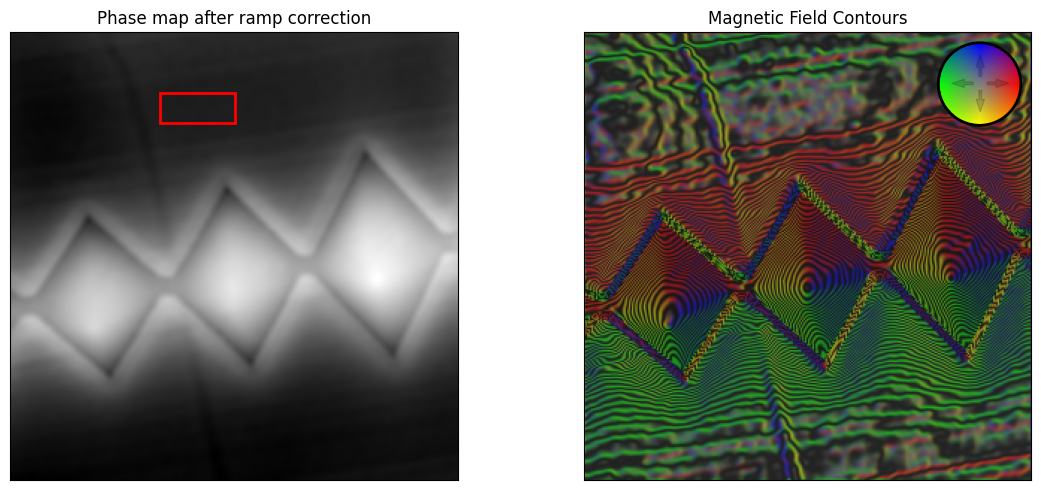

In [14]:
# Define cropping parameters
x_start, x_stop = 100, 400
y_start, y_stop = 100, 400

# Define contrast parameters
vmin_mul_bg = 0.5
vmax_mul_bg = 2.5
vmin_mul_overlay = -1
vmax_mul_overlay = 1

# Crop and process the phase image
phi_crop1 = phi_crop[y_start:y_stop, x_start:x_stop]  # Note: corrected indexing order
image1 = abs(phi_crop1)

# Apply Gaussian filter for smoothing
from scipy.ndimage import gaussian_filter
filtered_image = gaussian_filter(image1, sigma=1)

# Remove phase ramp
ramp_roi = np.s_[40:60, 100:150]
mean_phase_compensated, _, _ = remove_phase_ramp(img=filtered_image, roi=ramp_roi)

# Create full-size phase array for visualization
phase_f = np.zeros((512, 512))
phase_f[y_start:y_stop,x_start:x_stop] = mean_phase_compensated
#plt.imshow(phase_f)

# Create the visualization
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

# Left plot: Phase map with ramp correction ROI
rect = patches.Rectangle(
    (ramp_roi[1].start, ramp_roi[0].start),
    ramp_roi[1].stop - ramp_roi[1].start,
    ramp_roi[0].stop - ramp_roi[0].start,
    linewidth=2,
    edgecolor='red',
    facecolor='none',
)

ax[0].imshow(mean_phase_compensated, cmap='gray')
print(np.shape(mean_phase_compensated))
np.save('mean_phase_compensated.npy', mean_phase_compensated) # saving the mean phase compensated array

ax[0].add_patch(rect)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Phase map after ramp correction", fontsize=12)

# Right plot: Magnetic contour plot with background overlay
# First, show the background grayscale image
img_crop = in_focus.data[y_start:y_stop, x_start:x_stop]
background_extent = [x_start, x_stop, y_start, y_stop]
# Show the cropped image with specified contrast
ax[1].imshow(img_crop, cmap='gray',origin='lower', extent=background_extent,
             vmin=vmin_mul_bg * np.mean(in_focus.data),
             vmax=vmax_mul_bg * np.mean(in_focus.data))

# Store axis limits before plotting phase contours
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()

# Plot the magnetic field visualization using the full phase array
phase_field = plot_mag_induction(phase_f, axis=ax[1], binning=1)



# Show background image with extent matching the full coordinate system
ax[1].imshow(img_crop, cmap='gray', origin='lower', extent=background_extent,
             vmin=vmin_mul_bg * np.mean(in_focus.data),
             vmax=vmax_mul_bg * np.mean(in_focus.data),alpha=0.5)
# Restore axis properties and formatting
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].invert_yaxis()
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Magnetic Field Contours", fontsize=12)

plt.tight_layout()
plt.show()

<ins>Step 6.</ins> Calculating the magnetic information within the sample using equation 2
<br>The code gives the cumulative magnetic moment inside the sample

Calculates the X gradient and Y gradient of the image

In [15]:
def gradients(image,pixel_size):
    dim = image.shape
    grad_X = np.zeros((dim[0],dim[1]))
    grad_Y = np.zeros((dim[0],dim[1]))
    for i in range (0,dim[0]-1):
        for j in range (0,dim[1]-1):
            grad_X[i,j] =(image[i,j+1]-image[i,j])/pixel_size
            grad_Y[i,j] =-(image[i+1,j]-image[i,j])/pixel_size
    return(grad_X,grad_Y)

In [16]:
coeff = h/(2*pi*electron_charge)
(grad_X,grad_Y) = gradients(phi_crop,pixel_dimensions)

Bx = coeff*grad_Y/t
By = -coeff*grad_X/t

<ins>Step 6.</ins> Plotting the magnetic map within the specimen

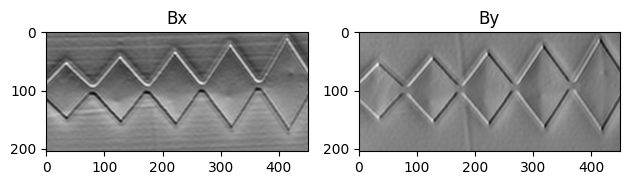

In [17]:
angle = 0
Bx_real = Bx*np.cos(angle)-By*np.cos(np.pi/2 -angle)
By_real = Bx*np.sin(angle)+By*np.sin(np.pi/2 -angle)

plt.subplot(1, 2, 1)
plt.imshow(rotate(Bx_real,-7)[165:370,30:480],cmap = 'gray')
plt.title('Bx') 
plt.subplot(1, 2, 2)
plt.imshow(rotate(By_real,-7)[165:370,30:480],cmap = 'gray')
plt.title('By')
plt.tight_layout()
plt.show()